### Laden der Daten in Hive

Zuerst habe ich die Daten der Kaggle Challenge lokal heruntergeladen und in das Volume der Namenode hineinkopiert, sodass es automatisch in das Dateisystem des Namenode Containers durchgeleitet wird. Danach habe ich auf der Kommandozeile der Namenode den Befehl `hadoop fs -mkdir -p workspace/eating_and_health` ausgeführt um ein Verzeichnis im HDFS zu erstellen, sodass ich direkt im Anschluss mittels `hadoop fs -copyFromLocal <path_to_local_kaggle_files> workspace/eating_and_health/` die Daten ins HDFS hineinkopieren konnte. 

Danach habe ich über das UI von Hue die Daten vom HDFS in Hive geladen, was in etwa folgendermaßen ausgesehen hat

![uebung_251](uebung_251.PNG)

und im nächsten Schritt so

![uebung_252](uebung_252.PNG)

Danach konnte man auch feststellen, dass die Daten im HDFS nun in das Verzeichnis `/user/hive/warehouse/ehresp_2014/ehresp_2014.csv` *verschoben* wurden, also werden die Daten von nun an von Hive verwaltet. 

### Cloudera Hive Treiber Installation

Wie in der Vorlesung beschrieben, habe ich den aktuellsten Hive JDBC Treiber von der [Cloudera Webseite](https://www.cloudera.com/downloads/connectors/hive/jdbc/2-6-2.html) herunter geladen und alle sich darin befindenden Ordner extrahiert. Nun müssen diese Treiber Dateien für die Applikation, die auf Hive zugreifen will, zugänglich sein. In meinem Fall ist befindet sich die Applikation auf diesem Jupyter Notebook Server, also in dem `jupyter-spark` Container in meinem `docker-compose` Netzwerk. Über ein Volume dieses Containers gelangen die Treiber Dateien dann in das `/drivers` Verzeichnis innerhalb dieses Containers. 

### Hive Zugriff über die Applikation
Zuerst müssen alle notwendigen Pakete geladen werden:

In [1]:
library(DBI)
library(rJava)
library(RJDBC)
library(corrplot)
library(ggplot2)

corrplot 0.84 loaded



Mit folgendem Befehl werden alle `.jar` (Java Archive) Dateien innerhalb des Hive JDBC Treibers der Version `2.6.2` aufgelistet:

In [2]:
# List all jar files in /drivers
cp = list.files(
    path=c('/drivers/ClouderaHiveJDBC-2.6.2.1002/ClouderaHiveJDBC4-2.6.2.1002'), 
    pattern='jar', 
    full.names=T, 
    recursive=T
)
print(cp)

[1] "/drivers/ClouderaHiveJDBC-2.6.2.1002/ClouderaHiveJDBC4-2.6.2.1002/HiveJDBC4.jar"


Mit folgendem Befehl wird eine Verbindung zu Hive erstellt, wobei man beachten muss, dass der `host` im Connection String `hiveserver`, also der Container Name des Hive Servers ist, was funktioniert, weil der `jupyer-spark` und `hiveserver` Container beide im gleichen `docker-compose` Netzwerk sind.

In [3]:
# Connect to Hive
.jinit()
drv = JDBC(
    driverClass="com.cloudera.hive.jdbc4.HS2Driver", 
    classPath=cp) 
conn = dbConnect(
    drv, 
    "jdbc:hive2://hiveserver:10000/default;AuthMech=3", 
    "hive", 
    "hive", 
    identifier.quote=" ")
show_databases = dbGetQuery(conn, "show databases")
print(show_databases)

  database_name
1       default


Im Anschluss werden die Daten der Tabelle `ehresp_2014` eingelesen. Hier ist vielleicht erwähnenswert, dass man im Big Data Kontext eigentlich keine ganzen Tabellen in den Hauptspeicher lesen sollte, aber da `ehresp_2014` eine relativ kleine Tabelle ist, macht das hier nicht so viel aus. 

In [4]:
# Read the data from Hive (make sure to upload ehresp_2014 into Hive first)
em <- dbGetQuery(conn, "select * from default.ehresp_2014 where euexercise > 0 and erbmi > 0")

In [5]:
# Check if table could be loaded sucessfully
summary(em)

 ehresp_2014.tucaseid ehresp_2014.tulineno ehresp_2014.eeincome1
 Min.   :2.014e+13    Min.   :1            Min.   :-3.000       
 1st Qu.:2.014e+13    1st Qu.:1            1st Qu.: 1.000       
 Median :2.014e+13    Median :1            Median : 1.000       
 Mean   :2.014e+13    Mean   :1            Mean   : 1.309       
 3rd Qu.:2.014e+13    3rd Qu.:1            3rd Qu.: 2.000       
 Max.   :2.014e+13    Max.   :1            Max.   : 3.000       
 ehresp_2014.erbmi ehresp_2014.erhhch ehresp_2014.erincome ehresp_2014.erspemch
 Min.   :13.00     Min.   :1.000      Min.   :-1.000       Min.   :-1.000      
 1st Qu.:23.60     1st Qu.:3.000      1st Qu.: 1.000       1st Qu.:-1.000      
 Median :26.60     Median :3.000      Median : 1.000       Median : 1.000      
 Mean   :27.77     Mean   :2.886      Mean   : 2.041       Mean   : 1.874      
 3rd Qu.:30.70     3rd Qu.:3.000      3rd Qu.: 3.000       3rd Qu.: 5.000      
 Max.   :73.60     Max.   :3.000      Max.   : 5.000       Max.  

Die Plots werden dann mittels folgenden Befehlen erstellt. Dabei ist evtl. zu beachten, dass jeder Spaltenname in meinem Fall mit `ehresp_2014.` beginnt. 

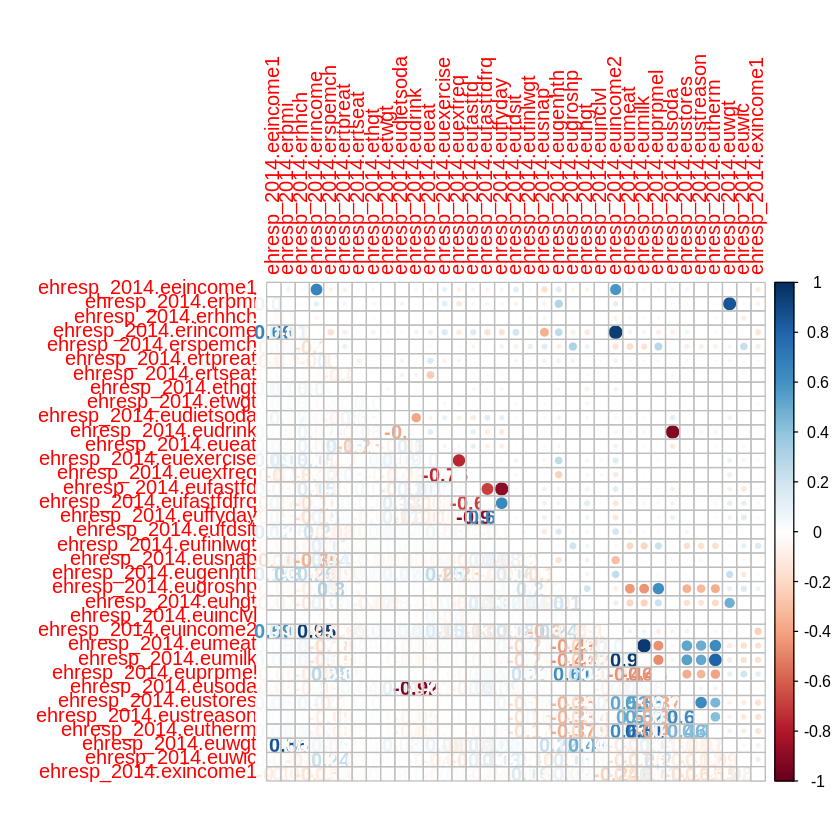

In [6]:
# Create plots
corrplot.mixed(corr=cor(em[,3:37]), tl.pos = "lt")

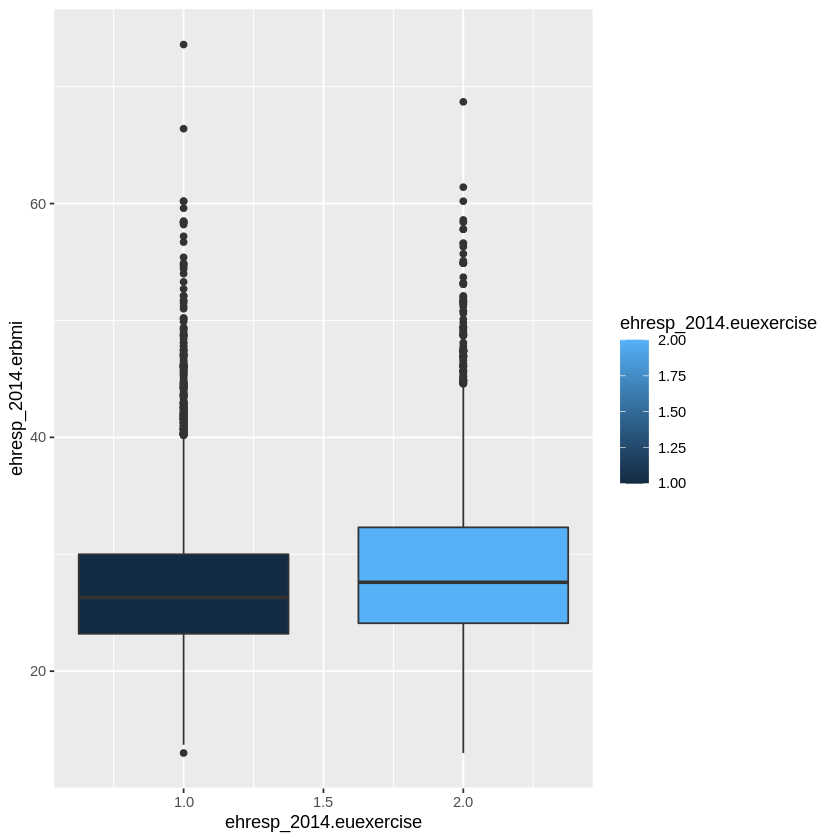

In [7]:
ggplot(em, aes(group=ehresp_2014.euexercise, 
               x=ehresp_2014.euexercise, 
               y=ehresp_2014.erbmi, 
               fill=ehresp_2014.euexercise)) + geom_boxplot()

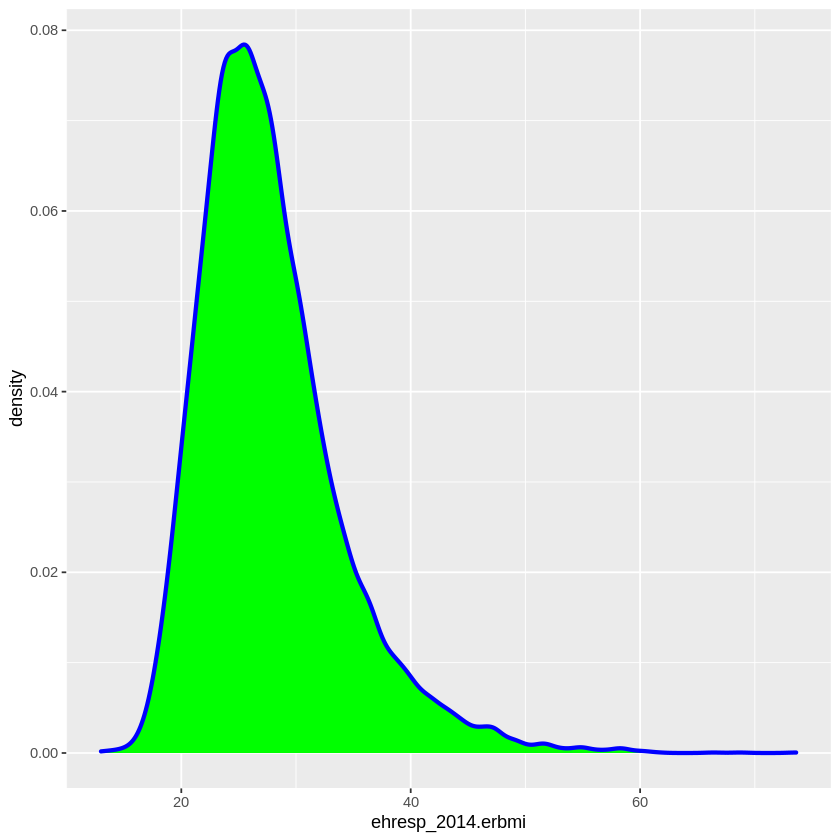

In [8]:
ggplot(em, aes(ehresp_2014.erbmi)) + geom_density(color='blue', fill='green', lwd=1.2)